In [1]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt

### Exploring Cleaned Data

In [2]:
CLEAN_DATA_PATH = "../data/cleaned"
RAW_DATA_PATH = "../data/raw"

In [6]:
filtered_data = pd.read_csv("../data/cleaned/final_df.csv")

## Quick Clean-up

In [7]:
filtered_data['date'] = pd.to_datetime(filtered_data['date'])
filtered_data = filtered_data[(filtered_data['date'] >= pd.Timestamp('2000-01-01')) & 
(filtered_data['theaters'] > 0)]

### Time series 

In [12]:
sov_df = pd.read_csv("../data/raw/sov_data.csv")


In [13]:
for c in ["date", "release_date"]:
    if c in sov_df.columns:
        sov_df[c] = pd.to_datetime(sov_df[c], errors="coerce")

if "gross_per_theater" not in sov_df.columns and {"gross", "theaters"}.issubset(sov_df.columns):
    sov_df["gross_per_theater"] = sov_df["gross"] / sov_df["theaters"]

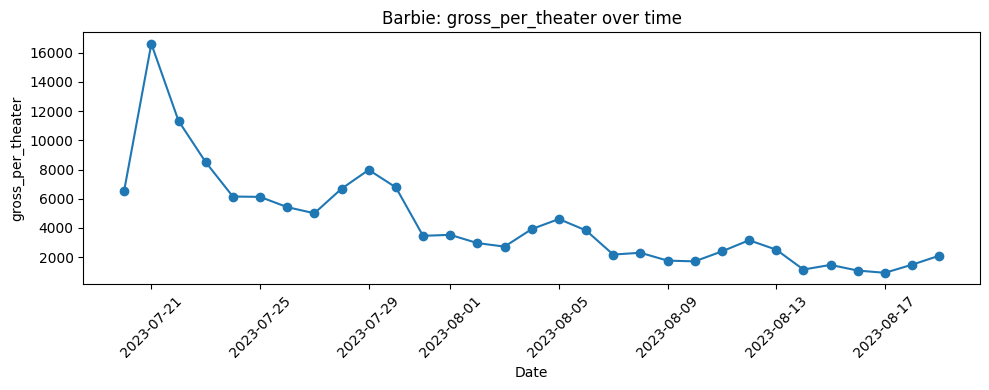

In [18]:
def plot_example_movie_timeseries(df, title, y_col="gross_per_theater"):
    subset = df[(df["title"] == title) & (df['gross_per_theater'])].copy()
    if subset.empty:
        print(f"No data for title: {title}")
        return
    
    subset = subset.sort_values("date")
    subset = subset[subset['date'] <= subset['release_date']+pd.Timedelta(days=30)]
    plt.figure(figsize=(10,4))
    plt.plot(subset["date"], subset[y_col], marker="o")
    plt.title(f"{title}: {y_col} over time")
    plt.xlabel("Date")
    plt.ylabel(y_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_example_movie_timeseries(sov_df, "Barbie")

In [23]:
filtered_data["is_weekday"] = filtered_data["weekday"]  # binary
filtered_data["day_label"] = filtered_data["is_weekday"].map({0: "Weekend", 1: "Weekday"})

,mean,25%,50%,75%
day_label,,,,
Weekday,156.942090,48.000000,97.800000,198.624730
Weekend,370.117082,94.288204,185.137732,380.798713


<Figure size 600x400 with 0 Axes>

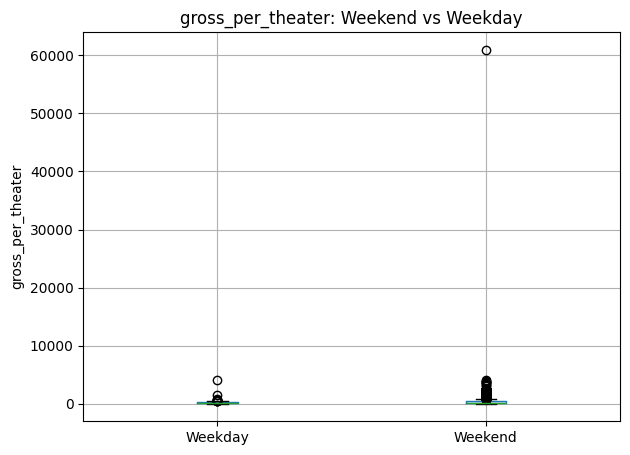

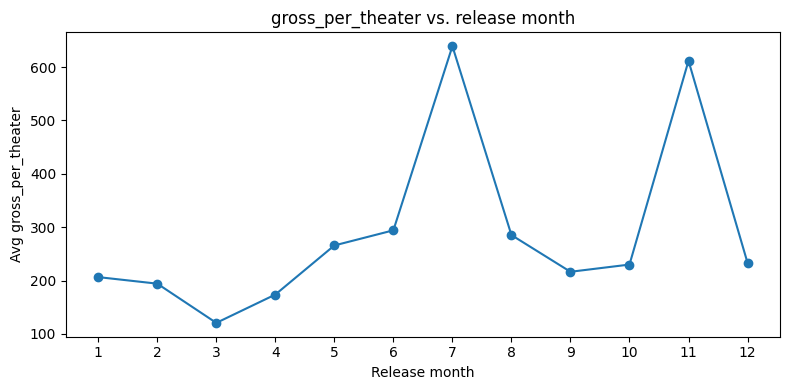

In [24]:
def plot_binary_weekday_effect(df, y_col="gross_per_theater"):
    if "day_label" not in df.columns:
        df["day_label"] = df["weekday"].map({0: "Weekend", 1: "Weekday"})
    
    grouped = df.groupby("day_label")[y_col].describe()[["mean","25%","50%","75%"]]
    display(grouped)

    plt.figure(figsize=(6,4))
    df.boxplot(column=y_col, by="day_label")
    plt.title(f"{y_col}: Weekend vs Weekday")
    plt.suptitle("")
    plt.xlabel("")
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

def plot_monthly_effect(df, y_col="gross_per_theater"):
    if "release_month" not in df.columns:
        df["release_month"] = df["release_date"].dt.month
    
    monthly = df.groupby("release_month")[y_col].mean()
    
    plt.figure(figsize=(8,4))
    monthly.plot(marker="o")
    plt.xticks(range(1,13))
    plt.xlabel("Release month")
    plt.ylabel(f"Avg {y_col}")
    plt.title(f"{y_col} vs. release month")
    plt.tight_layout()
    plt.show()


plot_binary_weekday_effect(filtered_data)
plot_monthly_effect(filtered_data)

### Genres

In [20]:
def compare_high_low_performers(df, y_col="gross_per_theater", q=0.25):
    tmp = df.copy()
    movie_stats = tmp.groupby("title")[y_col].mean().rename("avg_perf")
    tmp = tmp.merge(movie_stats, on="title")
    
    low_thresh = tmp["avg_perf"].quantile(q)
    high_thresh = tmp["avg_perf"].quantile(1-q)
    
    low = tmp[tmp["avg_perf"] <= low_thresh]
    high = tmp[tmp["avg_perf"] >= high_thresh]
    
    print(f"Low performers: <= {low_thresh:.2f}")
    print(f"High performers: >= {high_thresh:.2f}")
    
    # Compare popularity, runtime, vote_average
    for col in ["popularity", "runtime", "vote_average", "budget"]:
        if col in df.columns:
            print(f"\n=== {col} ===")
            display(pd.DataFrame({
                "low_mean": [low[col].mean()],
                "high_mean": [high[col].mean()]
            }))
    
    # Genre comparison
    if "genre_names" in df.columns:
        def explode_genres(sub):
            g = sub["genre_names"].dropna().str.split(",")
            g = g.explode().str.strip()
            return g
    
        high_genres = explode_genres(high).value_counts(normalize=True).head(10)
        low_genres = explode_genres(low).value_counts(normalize=True).head(10)
        
        print("\nTop genres among high performers:")
        display(high_genres)
        print("\nTop genres among low performers:")
        display(low_genres)

compare_high_low_performers(filtered_data)

Low performers: <= 40.47
High performers: >= 161.91

=== popularity ===


,low_mean,high_mean
0,3.325037,3.088348



=== runtime ===


,low_mean,high_mean
0,69.629175,74.967401



=== vote_average ===


,low_mean,high_mean
0,4.256506,4.450216



=== budget ===


,low_mean,high_mean
0,1.145160e+07,1.023241e+07



Top genres among high performers:


genre_names
Drama          0.245884
Comedy         0.115459
Thriller       0.091298
Horror         0.067137
Documentary    0.065213
Romance        0.064571
Action         0.055377
Crime          0.051101
Adventure      0.035279
Animation      0.031003
Name: proportion, dtype: float64


Top genres among low performers:


genre_names
Drama              0.206993
Comedy             0.109824
Thriller           0.102746
Horror             0.099743
Action             0.059202
Documentary        0.051266
Romance            0.050622
Animation          0.042042
Crime              0.042042
Science Fiction    0.038396
Name: proportion, dtype: float64

### Correlations

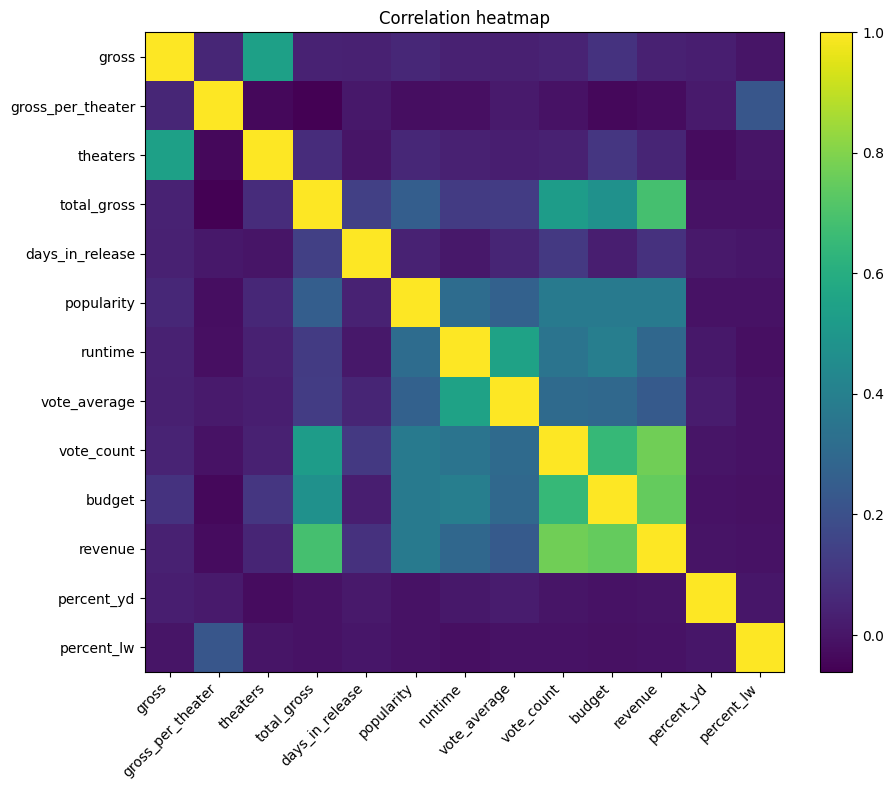

In [19]:
def plot_correlation_heatmap(df, cols=None):
    if cols is None:
        # choose a core set of numeric features
        cols = [
            "gross", "gross_per_theater", "theaters", "total_gross",
            "days_in_release", "popularity", "runtime",
            "vote_average", "vote_count", "budget", "revenue",
            "percent_yd", "percent_lw"
        ]
        cols = [c for c in cols if c in df.columns]
    
    corr = df[cols].corr()
    
    plt.figure(figsize=(10,8))
    im = plt.imshow(corr, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)
    plt.title("Correlation heatmap")
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(filtered_data)